In [2]:
# Importation Bibliothèques:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchvision.transforms as T
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
from torch.distributions import MultivariateNormal

In [3]:
# Création des réseaux de neurônes :

class Model_PPO(nn.Module):
    """ 
    Neural Network: Construction du réseau de neurônes.
    
    :param np_inputs: taille en entrée (espace d'états)
    :param nb_outputs: taille en sortie (espace d'actions -> actor, 1 -> critic)
    """
    def __init__(self, np_inputs, nb_outputs):
        super(Model_PPO, self).__init__()   
        self.layer1 = nn.Linear(np_inputs, 64)
        self.layer2 = nn.Linear(64, 64)
        #self.layer4 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, nb_outputs)
        torch.nn.init.uniform_(self.layer3.weight,0.003, 0.006)

    def forward(self, input1):
        """
        Passage de input1 dans le réseau (forward).
        :param input1: Tensor d'un état
        :return: Tensor de taille nb_outputs
        """
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        activation1 = F.relu(self.layer1(input1))
        activation2 = F.relu(self.layer2(activation1))
        #activation3 = F.relu(self.layer3(activation2))
        output = self.layer3(activation2)
        return output

In [4]:
# Itération sur l'environnement :
class Env_rollout:
    """ 
    Itération sur l'environnement pour la current policy.
    
    :param env: environnement choisi
    :param max_steps: nombre de steps maximal pour un épisode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
        self.batch_obs=[]
        self.batch_acts=[]
        self.batch_log_probs=[]
        self.batch_rews = []
    
    def reset(self):
        """
        Reset: réinitialisation des paramètres (listes et environnement).
        """
        self.prev_state = env.reset()
        self.batch_obs=[]
        self.batch_acts=[]
        self.batch_log_probs=[]
        self.batch_rews = []
    
    def iterations(self,actor_net, nbr_episodes):
        """
        Roll Out: on visite l'environnement sur un nombre de steps donné.
        :param actor_net: Politique appliquée à l'environnement
        :param nbr_episodes: Nombre d'épisodes
        :return: Tensors; batch des états, des actions
        """
        for ep in range(nbr_episodes):
            ep_rews = []
            prev_state = self.env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action = torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(prev_state), dim=0).float()))
                    if(action.dim()==0):
                        action=torch.unsqueeze(action,dim=0)
                    action_all=np.array([])
                    action_all=np.append(action_all,np.clip(action[0].detach().numpy(), -1.0, 1.0))
                    #action_all=np.append(action_all,np.argmax(action[1:4].detach().numpy()))
                    state, reward, done, _ = self.env.step(action_all)
                    self.batch_obs.append(prev_state)
                    self.batch_acts.append(action_all)
                    ep_rews.append(reward)
                    prev_state = state
                if done:
                    break
            self.batch_rews.append(ep_rews)
        return torch.tensor(self.batch_obs, dtype=torch.float), torch.tensor(self.batch_acts, dtype=torch.float)
    
    def iterations_rand(self,actor_net, cov_mat, batch_size):
        """
        Roll Out: on visite l'environnement sur un nombre de steps donné.
        :param actor_net: Politique appliquée à l'environnement
        :param cov_mat: Covariance matrice utilisée pour le modèle gaussien
        :param batch_size: Nombre d'itérations
        :return: Tensors; batch des états, des actions et des log_probabilités
        """
        t = 0
        while t<batch_size:
            ep_rews = []
            prev_state = self.env.reset()
            for step_ep in range(self.max_steps): 
                t += 1
                with torch.no_grad():
                    parameters_based = torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(prev_state), dim=0).float()))
                    if(parameters_based.dim()==0):
                        parameters_based=torch.unsqueeze(parameters_based,dim=0)
                    distribution_p = MultivariateNormal(parameters_based, cov_mat)
                    action = distribution_p.sample()
                    log_proba = distribution_p.log_prob(action)
                    action_all=np.array([])
                    action_all=np.append(action_all,np.clip(action[0].detach().numpy(), -1.0, 1.0))
                    #action_all=np.append(action_all,np.argmax(action[1:4].detach().numpy()))
                    state, reward, done, _ = self.env.step(action_all)
                    self.batch_obs.append(prev_state)
                    self.batch_acts.append(action.detach().numpy())
                    self.batch_log_probs.append(log_proba)
                    ep_rews.append(reward)
                    prev_state = state
                if done:
                    break
            self.batch_rews.append(ep_rews)
        return torch.tensor(self.batch_obs, dtype=torch.float), torch.tensor(self.batch_acts, dtype=torch.float), torch.tensor(self.batch_log_probs, dtype=torch.float)

    def immediate_rewards(self):
        """
        Immediate rewards: on transforme le batch des rewards pour récupérer la reward immédiate
        :return: Tensor; batch reward
        """
        batch_rewards = []
        for ep_rews in self.batch_rews:
            for rew in reversed(ep_rews):
                batch_rewards.insert(0,rew)
        return torch.tensor(batch_rewards, dtype=torch.float)
    
    def futur_rewards(self):
        """
        Futures rewards: on transforme le batch des rewards pour trouver l'expected return du couple step/action (vrai Q).
        :return: Tensor; batch reward-to-go
        """
        batch_rtgs = []
        for ep_rews in reversed(self.batch_rews):
            episodic_reward=0.0
            for rew in reversed(ep_rews):
                episodic_reward= rew + 0.99*episodic_reward
                batch_rtgs.insert(0,episodic_reward)
        return torch.tensor(batch_rtgs, dtype=torch.float)

In [5]:
class Algo_PPO():
    """ 
    Algorithme du PPO : apprentissage et tests.
    :param policy_class: politique (actor model)
    :param env: environnement choisi
    :param hyperparameters: hyperparamètres flottants ou entiers du modèle
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class(self.num_states, self.num_actions)
        self.critic_net = policy_class(self.num_states, 1)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.cov_var = torch.full(size=(self.num_actions,), fill_value=0.5)
        self.cov_mat = torch.diag(self.cov_var)
        self.rollout = Env_rollout(env, self.max_steps)
        self.ep_reward_list=[]
    
    def evaluate(self, nbr_episodes):
        """
        Evaluation du modèle
        :param nbr_episodes: nombre d'épisodes 
        """
        self.rollout.reset()
        state_batch, action_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        #batch_rtgs = self.rollout.futur_rewards()
        rew_batch = self.rollout.immediate_rewards()
        return state_batch, action_batch, rew_batch
        
    def train(self, nb_loop):
        """
        Apprentissage des réseaux. 
        :param nb_loop: nombre de loops 
        """
        for ep in range(nb_loop):
            state_batch,action_batch,log_prob_batch = self.rollout.iterations_rand(self.actor_net,self.cov_mat,self.batch_size)
            batch_rtgs = self.rollout.futur_rewards()
            batch_rews = self.rollout.immediate_rewards()
            for i in range(10):
                V_batch = torch.squeeze(self.critic_net(state_batch))
                advantage_batch = batch_rtgs - V_batch
                advantage_batch = (advantage_batch - advantage_batch.mean()) / (advantage_batch.std() + 1e-10)
                
                parameters_batch = torch.squeeze(self.actor_net(state_batch).unsqueeze(-1))
                if(parameters_batch.dim()==1):
                        parameters_batch=torch.unsqueeze(parameters_batch,dim=1)
                distribution_p = MultivariateNormal(parameters_batch, self.cov_mat)
                log_prob_current_batch = distribution_p.log_prob(action_batch)
                ratio_batch = torch.exp(log_prob_current_batch - log_prob_batch)
                ratio_loss = torch.mul(ratio_batch,advantage_batch)
                clip_loss = torch.mul(torch.clamp(ratio_loss, 0.8, 1.2),advantage_batch)
                actor_loss = (-torch.min(ratio_loss, clip_loss)).mean()

                criterion=nn.MSELoss(reduction='mean')
                critic_loss = criterion(V_batch.float(), batch_rtgs.float())
                self.optimizer_actor.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.optimizer_actor.step()
                self.optimizer_critic.zero_grad()
                critic_loss.backward()
                self.optimizer_critic.step()
                self.ep_reward_list.append(batch_rews.mean().numpy())
                avg_reward = np.mean(self.ep_reward_list[-30:])
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep*self.batch_size ))
            self.total_loop= self.total_loop +1
            self.rollout.reset()
        path='load_model/parameters/ppo-{num_algo:02d}-{name}-{epoch:03d}000.npy'
        with open(path.format(num_algo=self.num_algo,epoch=int(self.total_loop/1000),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialisation des hyperparamètres.
        :param hyperparameters: hyperparamètres flottants ou entiers du modèle
        """
        self.num_algo = 1
        self.max_steps = 90
        self.total_loop = 0
        self.batch_size = 2000
        self.gamma = 0.99
        self.critic_lr = 3e-4
        self.actor_lr = 3e-4
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        self.num_algo = num_algo
        self.total_loop = total_loop
        checkpoint_path1 = "load_model/weights/torch-ppo-{num_algo:02d}-actor-{epoch:03d}0.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/torch-ppo-{num_algo:02d}-critic-{epoch:03d}0.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
    
    def saving(self):
        checkpoint_path = "load_model/weights/torch-ppo-{num_algo:02d}-actor-{epoch:03d}0.pth"
        torch.save(self.actor_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/torch-ppo-{num_algo:02d}-critic-{epoch:03d}0.pth"
        torch.save(self.critic_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 

In [6]:
# Importation de l'environnement
problem = "Crossway_comparison2-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=36

algo=Algo_PPO(Model_PPO, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
algo.loading(36,1000)

C:\Users\zouil\anaconda3\envs\pytch\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [7]:
#Training
#algo.train(200)
#algo.saving()
algo.train(1000)
algo.saving()

Accident!
Accident!
Accident!
Episode * 0 * Avg Reward is ==> -10.234785079956055 And Number of steps is ==> 0
Accident!
Episode * 1 * Avg Reward is ==> -9.410374641418457 And Number of steps is ==> 2000
Episode * 2 * Avg Reward is ==> -8.478792190551758 And Number of steps is ==> 4000
Episode * 3 * Avg Reward is ==> -7.624678134918213 And Number of steps is ==> 6000
Accident!
Episode * 4 * Avg Reward is ==> -7.673707008361816 And Number of steps is ==> 8000
Episode * 5 * Avg Reward is ==> -8.512289047241211 And Number of steps is ==> 10000
Episode * 6 * Avg Reward is ==> -8.221787452697754 And Number of steps is ==> 12000
Episode * 7 * Avg Reward is ==> -7.716714859008789 And Number of steps is ==> 14000
Episode * 8 * Avg Reward is ==> -6.87525749206543 And Number of steps is ==> 16000
Episode * 9 * Avg Reward is ==> -6.836122035980225 And Number of steps is ==> 18000
Accident!
Episode * 10 * Avg Reward is ==> -6.52084493637085 And Number of steps is ==> 20000
Accident!
Episode * 11 *

Accident!
Accident!
Episode * 79 * Avg Reward is ==> -3.8822708129882812 And Number of steps is ==> 158000
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 80 * Avg Reward is ==> -4.332907199859619 And Number of steps is ==> 160000
Accident!
Accident!
Accident!
Accident!
Episode * 81 * Avg Reward is ==> -4.334679126739502 And Number of steps is ==> 162000
Accident!
Accident!
Episode * 82 * Avg Reward is ==> -5.583563804626465 And Number of steps is ==> 164000
Accident!
Accident!
Episode * 83 * Avg Reward is ==> -6.020756721496582 And Number of steps is ==> 166000
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 84 * Avg Reward is ==> -6.352948188781738 And Number of steps is ==> 168000
Episode * 85 * Avg Reward is ==> -5.073794364929199 And Number of steps is ==> 170000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 86 * Avg Reward is ==> -4.980062961578369 And Number of steps is ==> 172000
Accident!
Accident!
Episode * 87 * Avg Reward is ==

Accident!
Accident!
Accident!
Episode * 150 * Avg Reward is ==> -4.054864883422852 And Number of steps is ==> 300000
Episode * 151 * Avg Reward is ==> -3.651970863342285 And Number of steps is ==> 302000
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 152 * Avg Reward is ==> -4.01542854309082 And Number of steps is ==> 304000
Accident!
Accident!
Accident!
Accident!
Episode * 153 * Avg Reward is ==> -4.147505283355713 And Number of steps is ==> 306000
Accident!
Accident!
Accident!
Episode * 154 * Avg Reward is ==> -4.679150104522705 And Number of steps is ==> 308000
Accident!
Accident!
Accident!
Accident!
Episode * 155 * Avg Reward is ==> -4.792726516723633 And Number of steps is ==> 310000
Accident!
Accident!
Episode * 156 * Avg Reward is ==> -4.599143028259277 And Number of steps is ==> 312000
Accident!
Accident!
Accident!
Episode * 157 * Avg Reward is ==> -4.311341762542725 And Number of steps is ==> 314000
Accident!
Episode * 158 * Avg Reward is ==> -3.5918405055999756 A

Accident!
Episode * 220 * Avg Reward is ==> -2.5722339153289795 And Number of steps is ==> 440000
Accident!
Accident!
Accident!
Accident!
Episode * 221 * Avg Reward is ==> -2.85758376121521 And Number of steps is ==> 442000
Accident!
Accident!
Accident!
Episode * 222 * Avg Reward is ==> -2.7879748344421387 And Number of steps is ==> 444000
Episode * 223 * Avg Reward is ==> -2.8663995265960693 And Number of steps is ==> 446000
Episode * 224 * Avg Reward is ==> -2.3517301082611084 And Number of steps is ==> 448000
Accident!
Accident!
Accident!
Accident!
Episode * 225 * Avg Reward is ==> -2.4931447505950928 And Number of steps is ==> 450000
Accident!
Episode * 226 * Avg Reward is ==> -2.4469263553619385 And Number of steps is ==> 452000
Accident!
Accident!
Accident!
Episode * 227 * Avg Reward is ==> -2.9315431118011475 And Number of steps is ==> 454000
Accident!
Accident!
Accident!
Episode * 228 * Avg Reward is ==> -2.8353915214538574 And Number of steps is ==> 456000
Accident!
Episode * 

Accident!
Episode * 306 * Avg Reward is ==> -0.9536135196685791 And Number of steps is ==> 612000
Episode * 307 * Avg Reward is ==> -0.9773561954498291 And Number of steps is ==> 614000
Episode * 308 * Avg Reward is ==> -0.8057287335395813 And Number of steps is ==> 616000
Episode * 309 * Avg Reward is ==> -0.6378642916679382 And Number of steps is ==> 618000
Accident!
Episode * 310 * Avg Reward is ==> -0.6829877495765686 And Number of steps is ==> 620000
Episode * 311 * Avg Reward is ==> -0.7325910329818726 And Number of steps is ==> 622000
Episode * 312 * Avg Reward is ==> -0.7536599636077881 And Number of steps is ==> 624000
Episode * 313 * Avg Reward is ==> -0.8078089952468872 And Number of steps is ==> 626000
Accident!
Episode * 314 * Avg Reward is ==> -0.8544121384620667 And Number of steps is ==> 628000
Episode * 315 * Avg Reward is ==> -0.9645382165908813 And Number of steps is ==> 630000
Episode * 316 * Avg Reward is ==> -0.8247228264808655 And Number of steps is ==> 632000
Ep

Episode * 398 * Avg Reward is ==> -0.5417497754096985 And Number of steps is ==> 796000
Episode * 399 * Avg Reward is ==> -0.5659459829330444 And Number of steps is ==> 798000
Episode * 400 * Avg Reward is ==> -0.5435927510261536 And Number of steps is ==> 800000
Episode * 401 * Avg Reward is ==> -0.5316134095191956 And Number of steps is ==> 802000
Episode * 402 * Avg Reward is ==> -0.5013328790664673 And Number of steps is ==> 804000
Accident!
Episode * 403 * Avg Reward is ==> -0.6591219305992126 And Number of steps is ==> 806000
Episode * 404 * Avg Reward is ==> -0.7036563754081726 And Number of steps is ==> 808000
Episode * 405 * Avg Reward is ==> -0.7756043672561646 And Number of steps is ==> 810000
Episode * 406 * Avg Reward is ==> -0.6167940497398376 And Number of steps is ==> 812000
Episode * 407 * Avg Reward is ==> -0.5913382768630981 And Number of steps is ==> 814000
Episode * 408 * Avg Reward is ==> -0.48015663027763367 And Number of steps is ==> 816000
Episode * 409 * Avg R

Episode * 491 * Avg Reward is ==> -0.562460720539093 And Number of steps is ==> 982000
Episode * 492 * Avg Reward is ==> -0.5223944783210754 And Number of steps is ==> 984000
Episode * 493 * Avg Reward is ==> -0.4819755554199219 And Number of steps is ==> 986000
Episode * 494 * Avg Reward is ==> -0.44274643063545227 And Number of steps is ==> 988000
Episode * 495 * Avg Reward is ==> -0.43795067071914673 And Number of steps is ==> 990000
Episode * 496 * Avg Reward is ==> -0.45394039154052734 And Number of steps is ==> 992000
Accident!
Episode * 497 * Avg Reward is ==> -0.6057863831520081 And Number of steps is ==> 994000
Episode * 498 * Avg Reward is ==> -0.5928767919540405 And Number of steps is ==> 996000
Accident!
Episode * 499 * Avg Reward is ==> -0.6734244227409363 And Number of steps is ==> 998000
Episode * 500 * Avg Reward is ==> -0.5891194939613342 And Number of steps is ==> 1000000
Episode * 501 * Avg Reward is ==> -0.6052150726318359 And Number of steps is ==> 1002000
Episode 

Episode * 583 * Avg Reward is ==> -0.4592777490615845 And Number of steps is ==> 1166000
Episode * 584 * Avg Reward is ==> -0.4667515456676483 And Number of steps is ==> 1168000
Episode * 585 * Avg Reward is ==> -0.4828093945980072 And Number of steps is ==> 1170000
Episode * 586 * Avg Reward is ==> -0.5258402228355408 And Number of steps is ==> 1172000
Accident!
Episode * 587 * Avg Reward is ==> -0.6963528394699097 And Number of steps is ==> 1174000
Episode * 588 * Avg Reward is ==> -0.6756618618965149 And Number of steps is ==> 1176000
Episode * 589 * Avg Reward is ==> -0.6531133055686951 And Number of steps is ==> 1178000
Episode * 590 * Avg Reward is ==> -0.44253599643707275 And Number of steps is ==> 1180000
Episode * 591 * Avg Reward is ==> -0.412578284740448 And Number of steps is ==> 1182000
Episode * 592 * Avg Reward is ==> -0.4249851107597351 And Number of steps is ==> 1184000
Episode * 593 * Avg Reward is ==> -0.38016560673713684 And Number of steps is ==> 1186000
Episode * 

Episode * 675 * Avg Reward is ==> -0.3712787628173828 And Number of steps is ==> 1350000
Episode * 676 * Avg Reward is ==> -0.3701731264591217 And Number of steps is ==> 1352000
Accident!
Episode * 677 * Avg Reward is ==> -0.5068655610084534 And Number of steps is ==> 1354000
Episode * 678 * Avg Reward is ==> -0.5335835218429565 And Number of steps is ==> 1356000
Episode * 679 * Avg Reward is ==> -0.5399255156517029 And Number of steps is ==> 1358000
Episode * 680 * Avg Reward is ==> -0.417187362909317 And Number of steps is ==> 1360000
Episode * 681 * Avg Reward is ==> -0.5332666635513306 And Number of steps is ==> 1362000
Episode * 682 * Avg Reward is ==> -0.6002272963523865 And Number of steps is ==> 1364000
Episode * 683 * Avg Reward is ==> -0.6352203488349915 And Number of steps is ==> 1366000
Episode * 684 * Avg Reward is ==> -0.49043670296669006 And Number of steps is ==> 1368000
Episode * 685 * Avg Reward is ==> -0.41463717818260193 And Number of steps is ==> 1370000
Episode * 

KeyboardInterrupt: 

In [7]:
#Evaluation des résultats
states, actions, rewards = algo.evaluate(1000)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

In [9]:
import torch
import pandas as pd

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)
#LDV.isna().any()

def info_co2(states,LDV):
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    #print(torch_total_emission)
    print("\nLa consommation moyenne en CO2 est de {:.2f}mg et son écart-type est de {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(states,LDV)
    #temps passage voiture
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.])# respectivement: temps passage voiture / piéton
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\nLes temps moyens:")
    print("total: {:.2f} s".format(total_temps_mean[0].item()))
    print("voiture: {:.2f} s".format(total_temps_mean[1].item()))
    print("piéton: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

La vitesse moyenne (voiture) est de 6.65 m/s et son écart-type est de 3.22 m/s

L'accélération moyenne (voiture) est de -0.08 m/s2 et son écart-type est de 1.56 m/s2

La vitesse moyenne (piéton) est de 0.99 m/s et son écart-type est de 0.37 m/s

La consommation moyenne en CO2 est de 18042.04mg et son écart-type est de 11967.67 mg

Les temps moyens:
total: 9.94 s
voiture: 4.87 s
piéton: 6.59 s


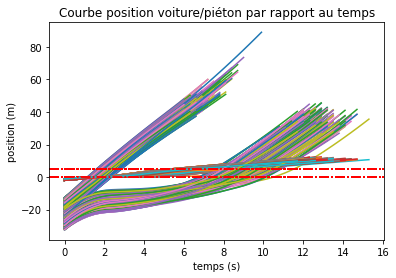

In [8]:
#Positions des agents
t=0
plt.title("Courbe position voiture/piéton par rapport au temps")
plt.xlabel("temps (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

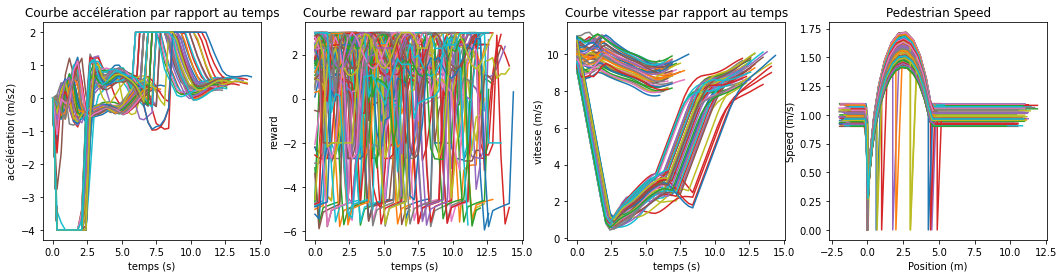

In [20]:
#Accélération, Reward, Vitesse de la voiture
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))

t=0
ax1.set_title("Courbe accélération par rapport au temps")
ax1.set_xlabel("temps (s)")
ax1.set_ylabel("accélération (m/s2)")

ax2.set_title("Courbe reward par rapport au temps")
ax2.set_xlabel("temps (s)")
ax2.set_ylabel("reward")

ax3.set_title("Courbe vitesse par rapport au temps")
ax3.set_xlabel("temps (s)")
ax3.set_ylabel("vitesse (m/s)")

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Position (m)")
ax4.set_ylabel("Speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t],ep_speed_car[t_init:t])
    ax4.plot(states[t_init:t,4],states[t_init:t,3])
    t+=1


In [10]:
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
    if(choice):
        cross_speed.append(np.array(ep_speed_car[t_init:t_init+37]))
        cross_acc.append(np.array(states[t_init:t_init+37,0]))
    else:
        wait_speed.append(np.array(ep_speed_car[t_init:t_init+17]))
        wait_acc.append(np.array(states[t_init:t_init+17,0]))
    t+=1
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

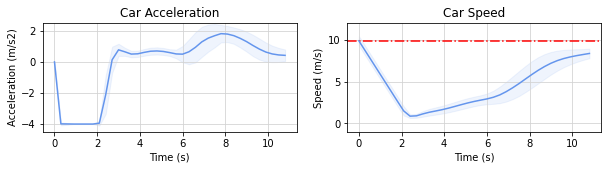

In [12]:
x1=[0.3*i for i in range(37)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
#fig.savefig("car_cross_ppo3.pdf")


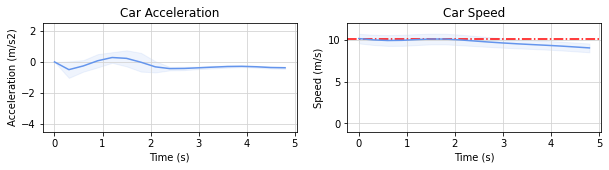

In [13]:
x1=[0.3*i for i in range(17)]
mean_speed=np.mean(wait_speed,axis=0)
std_speed=np.std(wait_speed,axis=0)
mean_acc=np.mean(wait_acc,axis=0)
std_acc=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
#fig.savefig("car_wait_ppo3.pdf")

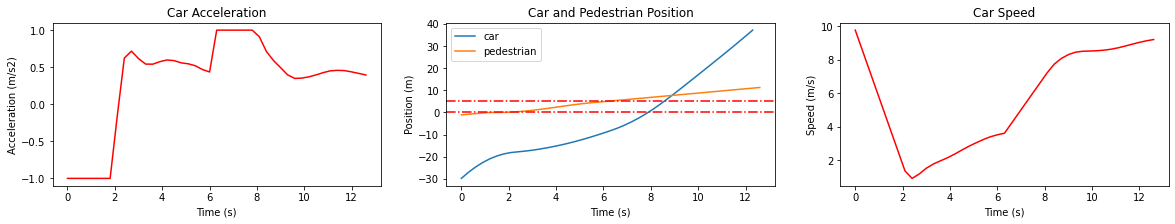

In [144]:
#Résumé du batch de test
#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-1.1,1.1)
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')
#ax2.plot(ep_time[t_init:t+1],states[t_init:t+1,0],color='b')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')
t+=1

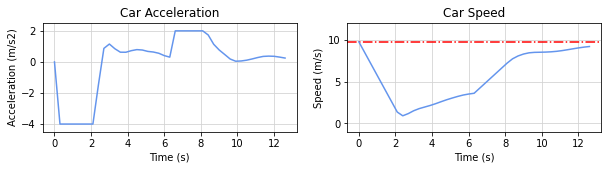

In [145]:
t-=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(ep_time[t_init:t+1],states[t_init:t+1,0],color='cornflowerblue')
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=ep_speed_car[t_init], color='r', linestyle='-.')
ax2.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='cornflowerblue')
ax2.grid(True,color='lightgrey')
fig.savefig("car_cross_ppo3.pdf")
t+=1


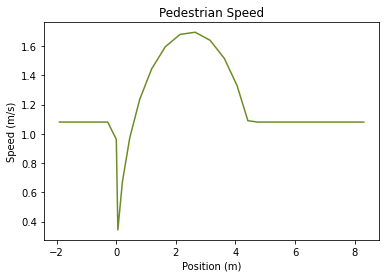

In [225]:
plt.title('Pedestrian Speed')
plt.xlabel("Position (m)")
plt.ylabel("Speed (m/s)")
plt.plot(states[t_init:t-10,4],states[t_init:t-10,3], color='olivedrab')
plt.savefig("ped_speed.pdf")